<a href="https://colab.research.google.com/github/sujitpal/deeplearning-ai-examples/blob/master/tricks01_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tricks to improve CIFAR-10 classifier

Slide below is taken from Lecture 3 of [Deep Learning (with Pytorch)](https://www.youtube.com/playlist?list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq) course from New York University.

We will look at doing the following:
* Normalize Input variables
* Schedule to decrease learning rate
* L1 / L2 regularization on weights (weight decay)
* Dropout for regularization

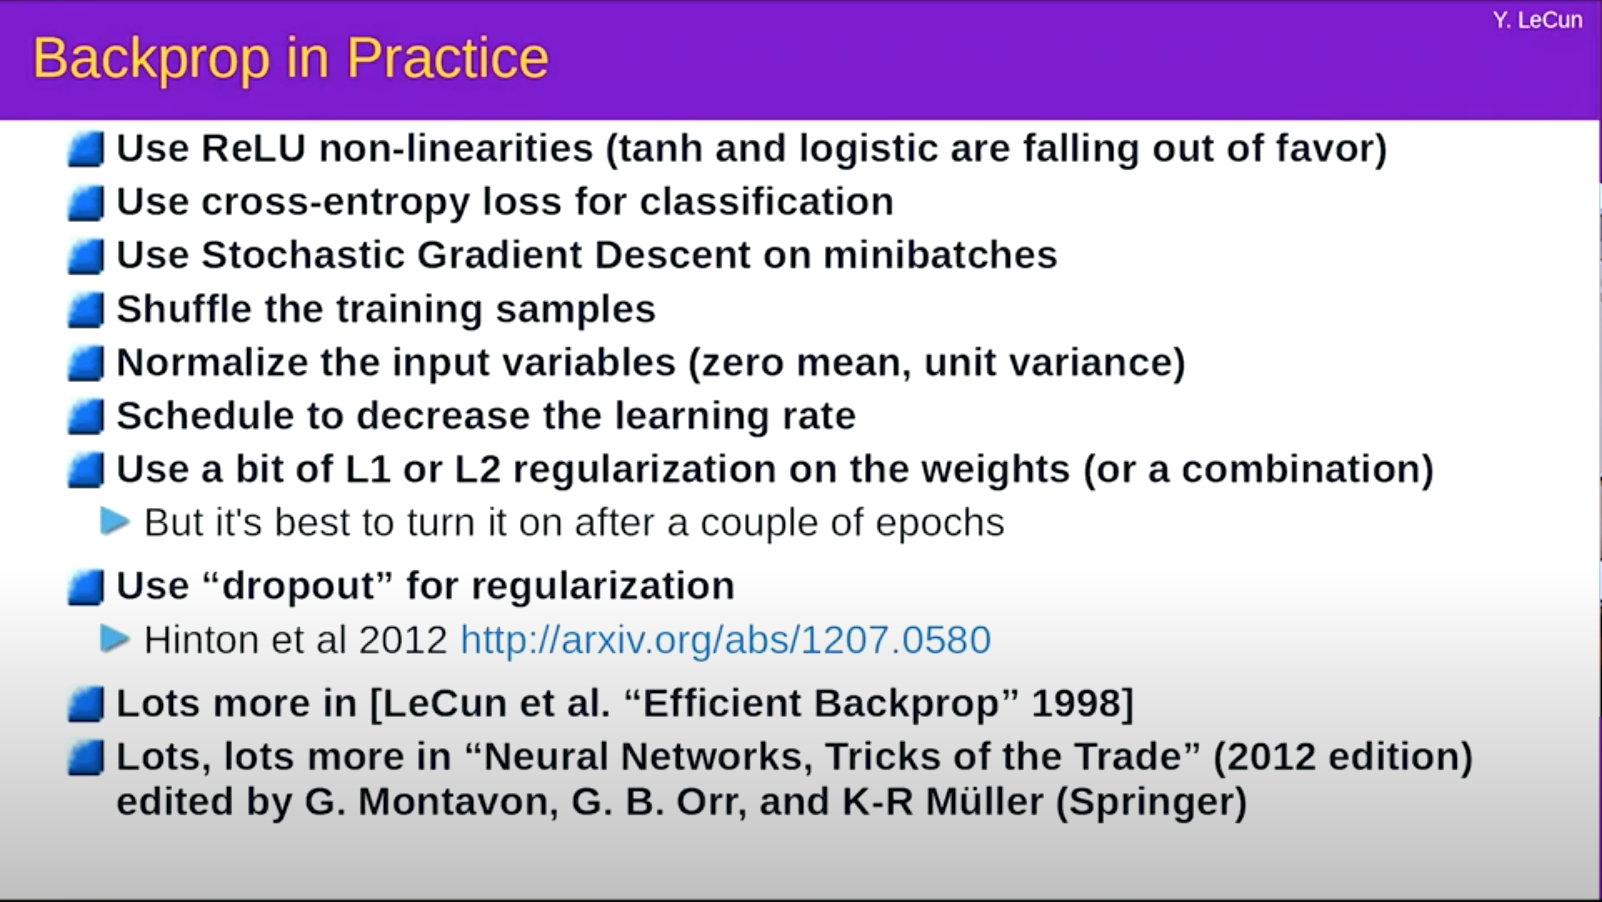

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline

In [2]:
TRAIN_IMAGES_DIR = "cifar10-train"
TEST_IMAGES_DIR = "cifar10-test"
MODEL_DIR = "models"

shutil.rmtree(MODEL_DIR, ignore_errors=True)
os.mkdir(MODEL_DIR)

In [3]:
CIFAR10_LABELS = [
  "aircraft", "automobile", "bird", "cat", "deer", 
  "dog", "frog", "horse", "ship", "truck"
]
idx2label = {i:x for i, x in enumerate(CIFAR10_LABELS)}
label2idx = {v:k for k, v in idx2label.items()}

len(idx2label), len(label2idx)

(10, 10)

### Baseline

* Data from `torchvision.datasets.CIFAR10`.
* Model based on [Tensorflow CNN Tutorial](https://www.tensorflow.org/tutorials/images/cnn).

#### Data

In [4]:
train_ds = torchvision.datasets.CIFAR10(TRAIN_IMAGES_DIR,
                                        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                        ]),
                                        train=True, download=True)
test_ds = torchvision.datasets.CIFAR10(TEST_IMAGES_DIR, 
                                       transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor()                      
                                       ]),
                                       train=False, download=True)

Extracting cifar10-train/cifar-10-python.tar.gz to cifar10-train


Extracting cifar10-test/cifar-10-python.tar.gz to cifar10-test


In [5]:
BATCH_SIZE = 64

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_dl), len(test_dl)

(782, 157)

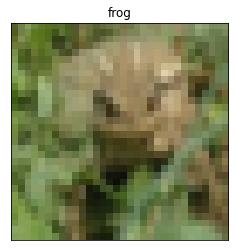

In [6]:
def show_data(image_label):
  image, label = image_label
  image = torch.transpose(torch.transpose(image, 0, 1), 1, 2)
  plt.title(idx2label[label])
  plt.xticks([])
  plt.yticks([])
  _ = plt.imshow(image)

show_data(train_ds[np.random.randint(low=0, high=len(train_dl))])

#### Model

In [7]:
class Cifar10Classifier(nn.Module):
  def __init__(self, use_spatial_dropout=False, use_dropout=False):
    super(Cifar10Classifier, self).__init__()
    # input parameters
    self.use_spatial_dropout = use_spatial_dropout
    self.use_dropout = use_dropout
    # layer definitions
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3))
    self.conv1_dropout = nn.Dropout2d(p=0.2)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
    self.conv2_dropout = nn.Dropout2d(p=0.2)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3))
    self.conv3_dropout = nn.Dropout2d(p=0.2)
    self.flatten = nn.Flatten()
    self.dense1 = nn.Linear(2304, 64)
    self.dense_dropout = nn.Dropout(p=0.2)
    self.dense2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    if self.use_spatial_dropout:
      x = self.conv1_dropout(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    if self.use_spatial_dropout:
      x = self.conv2_dropout(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = F.relu(x)
    if self.use_dropout:
      x = self.dense_dropout(x)
    x = self.dense2(x)
    x = F.log_softmax(x, dim=1)
    return x


model_0 = Cifar10Classifier()
model_0

Cifar10Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_dropout): Dropout2d(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_dropout): Dropout2d(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_dropout): Dropout2d(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=2304, out_features=64, bias=True)
  (dense_dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
# self-test
x = torch.rand(BATCH_SIZE, 3, 32, 32)
y = model_0(x)
print("y.size():", y.size())

y.size(): torch.Size([64, 10])


In [9]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_0 = model_0.to(dev)

#### Training

In [10]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [12]:
def train(model, train_dl, loss_fn, optimizer):
  model.train()
  train_losses, train_accs = [], []
  for batch in train_dl:
    images, labels = batch
    
    images = images.to(dev)
    labels = labels.to(dev)

    logits = model(images)
    loss = loss_fn(logits, labels)
    
    train_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    train_accs.append(accuracy_score(preds, labels))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # if len(train_losses) > 5:
    #   break
  
  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  return train_loss, train_acc


# # self-test
# train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
# train_loss, train_acc

In [13]:
def validate(model, val_dl, loss_fn):
  model.eval()
  val_losses, val_accs = [], []
  for batch in val_dl:
    images, labels = batch

    images = images.to(dev)
    labels = labels.to(dev)

    with torch.no_grad():
      logits = model(images)
      loss = loss_fn(logits, labels)

    val_losses.append(loss.item())
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    val_accs.append(accuracy_score(preds, labels))

    # if len(val_losses) > 5:
    #   break

  val_loss = sum(val_losses) / len(val_losses)
  val_acc = sum(val_accs) / len(val_accs)
  return val_loss, val_acc


# # self-test
# val_loss, val_acc = validate(model_0, test_dl, loss_fn)
# val_loss, val_acc

In [14]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_0, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_0, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)


Epoch  1 | Train Loss: 1.622, Accuracy: 0.410 | Validation Loss: 1.378, Accuracy: 0.512
Epoch  2 | Train Loss: 1.295, Accuracy: 0.540 | Validation Loss: 1.211, Accuracy: 0.575
Epoch  3 | Train Loss: 1.157, Accuracy: 0.590 | Validation Loss: 1.114, Accuracy: 0.607
Epoch  4 | Train Loss: 1.059, Accuracy: 0.628 | Validation Loss: 1.055, Accuracy: 0.632
Epoch  5 | Train Loss: 0.992, Accuracy: 0.653 | Validation Loss: 1.029, Accuracy: 0.639
Epoch  6 | Train Loss: 0.939, Accuracy: 0.672 | Validation Loss: 0.991, Accuracy: 0.654
Epoch  7 | Train Loss: 0.899, Accuracy: 0.686 | Validation Loss: 0.977, Accuracy: 0.659
Epoch  8 | Train Loss: 0.864, Accuracy: 0.700 | Validation Loss: 0.950, Accuracy: 0.672
Epoch  9 | Train Loss: 0.826, Accuracy: 0.714 | Validation Loss: 0.941, Accuracy: 0.675
Epoch 10 | Train Loss: 0.800, Accuracy: 0.720 | Validation Loss: 0.950, Accuracy: 0.670


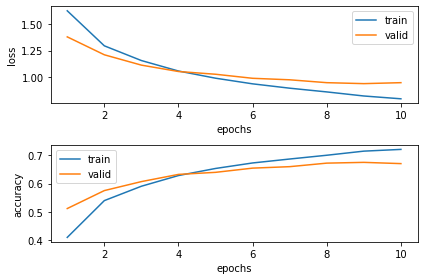

In [15]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
  plt.subplot(2, 1, 1)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_losses, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_losses, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(NUM_EPOCHS)+1, train_accs, label="train")
  plt.plot(np.arange(NUM_EPOCHS)+1, val_accs, label="valid")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  plt.tight_layout()
  _ = plt.plot()


plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [16]:
model_filepath = os.path.join(MODEL_DIR, "model_0.pkl")
torch.save(model_0, model_filepath)

#### Evaluation

In [17]:
def evaluate(model, test_dl):
  model.eval()
  true_values, pred_values = [], []
  for batch in test_dl:
    images, labels = batch
    images = images.to(dev)

    with torch.no_grad():
      logits = model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.numpy()

    true_values.extend(labels.tolist())
    pred_values.extend(preds.tolist())

  return true_values, pred_values


true_values, pred_values = evaluate(model_0, test_dl)

In [18]:
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.671
--
confusion matrix
[[751  40  71  10   6   3  10   9  54  46]
 [ 21 865  11   6   1   2   9   2  11  72]
 [ 72  18 660  53  37  43  55  40   6  16]
 [ 23  26 130 493  40 143  64  47   8  26]
 [ 39  10 205  68 419  33  76 133  10   7]
 [ 19  12 115 178  27 534  27  69   6  13]
 [  7  14  74  61  19  23 774  11   5  12]
 [ 21   8  70  33  36  48   7 750   3  24]
 [114  67  27  18   5   4   7   4 705  49]
 [ 32 145  10  16   1   5   5  11  16 759]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.68      0.75      0.72      1000
  automobile       0.72      0.86      0.78      1000
        bird       0.48      0.66      0.56      1000
         cat       0.53      0.49      0.51      1000
        deer       0.71      0.42      0.53      1000
         dog       0.64      0.53      0.58      1000
        frog       0.75      0.77      0.76      1000
       horse       0.70      0.75      0.72      1000
        ship      

In [19]:
def write_metrics(true_values, pred_values, experiment_name, metric_filepath):
  fout = open(metric_filepath, "w")
  p, r, f, s = precision_recall_fscore_support(true_values, pred_values, average="micro")
  metrics_dict = {
    "precision": p, "recall": r, "f1-score": f, "support": s
  }
  metrics_dict["name"] = experiment_name
  fout.write(json.dumps(metrics_dict))
  fout.close()


metric_filepath = os.path.join(MODEL_DIR, "model_0.json")
write_metrics(true_values, pred_values, "baseline", metric_filepath)

### Normalize Input

#### Data

In [20]:
norm_mean = np.round(train_ds.data.mean(axis=(0, 1, 2)) / 255, 4).tolist()
norm_std = np.round(train_ds.data.std(axis=(0, 1, 2)) / 255, 4).tolist()

norm_mean, norm_std

([0.4914, 0.4822, 0.4465], [0.247, 0.2435, 0.2616])

In [21]:
train_ds = torchvision.datasets.CIFAR10(TRAIN_IMAGES_DIR,
                                        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=norm_mean, std=norm_std)
                                        ]),
                                        train=True, download=True)
test_ds = torchvision.datasets.CIFAR10(TEST_IMAGES_DIR, 
                                       transform=torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor(),
                                         torchvision.transforms.Normalize(mean=norm_mean, std=norm_std)
                                       ]),
                                       train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


#### Model

In [22]:
model_1 = Cifar10Classifier()
model_1 = model_1.to(dev)

optimizer = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

#### Train

In [23]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_1, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_1, test_dl, loss_fn)
  print("Epoch {:2d} | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch  1 | Train Loss: 1.654, Accuracy: 0.399 | Validation Loss: 1.417, Accuracy: 0.486
Epoch  2 | Train Loss: 1.326, Accuracy: 0.526 | Validation Loss: 1.217, Accuracy: 0.570
Epoch  3 | Train Loss: 1.184, Accuracy: 0.580 | Validation Loss: 1.219, Accuracy: 0.570
Epoch  4 | Train Loss: 1.091, Accuracy: 0.618 | Validation Loss: 1.091, Accuracy: 0.614
Epoch  5 | Train Loss: 1.020, Accuracy: 0.643 | Validation Loss: 1.031, Accuracy: 0.640
Epoch  6 | Train Loss: 0.963, Accuracy: 0.664 | Validation Loss: 1.026, Accuracy: 0.641
Epoch  7 | Train Loss: 0.923, Accuracy: 0.677 | Validation Loss: 0.979, Accuracy: 0.668
Epoch  8 | Train Loss: 0.883, Accuracy: 0.695 | Validation Loss: 0.949, Accuracy: 0.674
Epoch  9 | Train Loss: 0.852, Accuracy: 0.705 | Validation Loss: 0.948, Accuracy: 0.672
Epoch 10 | Train Loss: 0.827, Accuracy: 0.714 | Validation Loss: 0.956, Accuracy: 0.676


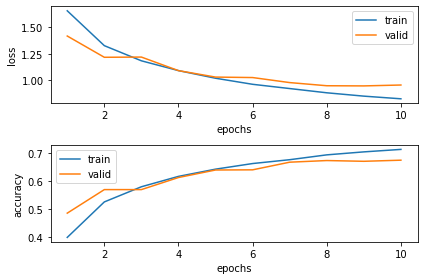

In [24]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [25]:
model_filepath = os.path.join(MODEL_DIR, "model_1.pkl")
torch.save(model_1, model_filepath)

#### Evaluate

In [26]:
true_values, pred_values = evaluate(model_1, test_dl)
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.675
--
confusion matrix
[[682  10  55  33  40   8   9  14 112  37]
 [ 29 723  15  18  12   7  20  14  38 124]
 [ 52   1 475  93 179  70  67  34  17  12]
 [  9   5  51 562 114 109  74  41  20  15]
 [ 12   0  43  68 727  14  62  57  12   5]
 [  8   2  49 257  69 503  31  64   8   9]
 [  2   0  41  70  60   9 793   8  11   6]
 [  9   2  31  49 116  56  10 713   3  11]
 [ 62  24  11  24  16   5   6   7 814  31]
 [ 33  54  12  28  16   2  17  36  39 763]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.76      0.68      0.72      1000
  automobile       0.88      0.72      0.79      1000
        bird       0.61      0.47      0.53      1000
         cat       0.47      0.56      0.51      1000
        deer       0.54      0.73      0.62      1000
         dog       0.64      0.50      0.56      1000
        frog       0.73      0.79      0.76      1000
       horse       0.72      0.71      0.72      1000
        ship      

In [27]:
metric_filepath = os.path.join(MODEL_DIR, "model_1.json")
write_metrics(true_values, pred_values, "norm_inputs", metric_filepath)

### Learning Rate Schedule

#### Model

In [28]:
model_2 = Cifar10Classifier()
model_2 = model_2.to(dev)

optimizer = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE*2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

#### Train

In [29]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_2, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_2, test_dl, loss_fn)
  print("Epoch {:2d} (LR: {:.3e}) | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, scheduler.get_last_lr()[0], train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  scheduler.step()


Epoch  1 (LR: 2.000e-03) | Train Loss: 1.523, Accuracy: 0.447 | Validation Loss: 1.287, Accuracy: 0.533
Epoch  2 (LR: 1.600e-03) | Train Loss: 1.176, Accuracy: 0.580 | Validation Loss: 1.119, Accuracy: 0.603
Epoch  3 (LR: 1.280e-03) | Train Loss: 1.033, Accuracy: 0.637 | Validation Loss: 1.059, Accuracy: 0.628
Epoch  4 (LR: 1.024e-03) | Train Loss: 0.950, Accuracy: 0.667 | Validation Loss: 0.992, Accuracy: 0.657
Epoch  5 (LR: 8.192e-04) | Train Loss: 0.889, Accuracy: 0.689 | Validation Loss: 0.960, Accuracy: 0.671
Epoch  6 (LR: 6.554e-04) | Train Loss: 0.847, Accuracy: 0.706 | Validation Loss: 0.948, Accuracy: 0.671
Epoch  7 (LR: 5.243e-04) | Train Loss: 0.808, Accuracy: 0.721 | Validation Loss: 0.949, Accuracy: 0.675
Epoch  8 (LR: 4.194e-04) | Train Loss: 0.783, Accuracy: 0.727 | Validation Loss: 0.921, Accuracy: 0.684
Epoch  9 (LR: 3.355e-04) | Train Loss: 0.760, Accuracy: 0.737 | Validation Loss: 0.936, Accuracy: 0.686
Epoch 10 (LR: 2.684e-04) | Train Loss: 0.740, Accuracy: 0.744 | 

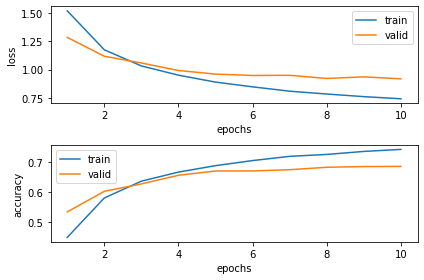

In [30]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [31]:
model_filepath = os.path.join(MODEL_DIR, "model_2.pkl")
torch.save(model_2, model_filepath)

#### Evaluate

In [32]:
true_values, pred_values = evaluate(model_2, test_dl)
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.688
--
confusion matrix
[[726  21  58  14   8   6   6  18  93  50]
 [ 22 800   8  10   4   5   6   4  39 102]
 [ 72  10 594  55  82  68  41  49  16  13]
 [ 21  15  75 474  59 186  61  62  28  19]
 [ 25   7  90  59 567  49  48 128  19   8]
 [ 14   7  65 160  35 599  12  83  13  12]
 [  7   8  61  74  46  33 734  15  10  12]
 [ 15   5  29  30  53  57   5 778   7  21]
 [ 53  33  13  15   6   4   4   8 823  41]
 [ 28  88  13  13   6   6   7  22  37 780]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.74      0.73      0.73      1000
  automobile       0.80      0.80      0.80      1000
        bird       0.59      0.59      0.59      1000
         cat       0.52      0.47      0.50      1000
        deer       0.65      0.57      0.61      1000
         dog       0.59      0.60      0.60      1000
        frog       0.79      0.73      0.76      1000
       horse       0.67      0.78      0.72      1000
        ship      

In [33]:
metric_filepath = os.path.join(MODEL_DIR, "model_2.json")
write_metrics(true_values, pred_values, "lr_schedule", metric_filepath)

### L1/L2 regularization (weight decay)

Weight decay is the same as L2 regularization. The sum of squared weights is added to the loss function. Effect is to keep weights small and avoid exploding the gradient, and prevents overfitting by making model more robust to adversarial input tweaking.

Paper reference: [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) (Loschilov et al, 2017).

#### Model

In [34]:
model_3 = Cifar10Classifier()
model_3 = model_3.to(dev)

optimizer = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE*2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

#### Train

In [35]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_3, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_3, test_dl, loss_fn)
  print("Epoch {:2d} (LR: {:.3e}) | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, scheduler.get_last_lr()[0], train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  scheduler.step()


Epoch  1 (LR: 2.000e-03) | Train Loss: 1.565, Accuracy: 0.430 | Validation Loss: 1.317, Accuracy: 0.526
Epoch  2 (LR: 1.600e-03) | Train Loss: 1.236, Accuracy: 0.556 | Validation Loss: 1.234, Accuracy: 0.560
Epoch  3 (LR: 1.280e-03) | Train Loss: 1.103, Accuracy: 0.608 | Validation Loss: 1.117, Accuracy: 0.606
Epoch  4 (LR: 1.024e-03) | Train Loss: 1.020, Accuracy: 0.640 | Validation Loss: 1.062, Accuracy: 0.626
Epoch  5 (LR: 8.192e-04) | Train Loss: 0.960, Accuracy: 0.660 | Validation Loss: 1.013, Accuracy: 0.644
Epoch  6 (LR: 6.554e-04) | Train Loss: 0.919, Accuracy: 0.679 | Validation Loss: 0.987, Accuracy: 0.659
Epoch  7 (LR: 5.243e-04) | Train Loss: 0.888, Accuracy: 0.690 | Validation Loss: 0.983, Accuracy: 0.657
Epoch  8 (LR: 4.194e-04) | Train Loss: 0.862, Accuracy: 0.699 | Validation Loss: 0.964, Accuracy: 0.663
Epoch  9 (LR: 3.355e-04) | Train Loss: 0.842, Accuracy: 0.706 | Validation Loss: 0.959, Accuracy: 0.665
Epoch 10 (LR: 2.684e-04) | Train Loss: 0.826, Accuracy: 0.711 | 

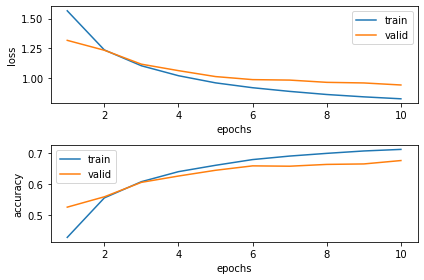

In [36]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [37]:
model_filepath = os.path.join(MODEL_DIR, "model_3.pkl")
torch.save(model_3, model_filepath)

#### Evaluate

In [38]:
true_values, pred_values = evaluate(model_3, test_dl)
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.676
--
confusion matrix
[[736  31  43  14  14  15  12  15  80  40]
 [ 22 809   7   8   4   9  14   9  28  90]
 [ 76   9 474  56 113 110  85  44  17  16]
 [ 18  10  65 397  64 278  87  44  21  16]
 [ 31   5  79  41 592  69  76  88  15   4]
 [ 16   5  51 100  39 705  28  42   6   8]
 [  6   4  38  47  33  41 802  11  10   8]
 [ 19   5  31  35  53 103   7 728   5  14]
 [ 77  40  15   9   8  16  11   6 787  31]
 [ 33 121  10  15   6   7  15  21  44 728]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.71      0.74      0.72      1000
  automobile       0.78      0.81      0.79      1000
        bird       0.58      0.47      0.52      1000
         cat       0.55      0.40      0.46      1000
        deer       0.64      0.59      0.61      1000
         dog       0.52      0.70      0.60      1000
        frog       0.71      0.80      0.75      1000
       horse       0.72      0.73      0.73      1000
        ship      

In [39]:
metric_filepath = os.path.join(MODEL_DIR, "model_3.json")
write_metrics(true_values, pred_values, "weight_decay", metric_filepath)

### Dropout (after Dense layer only)

#### Model

In [40]:
model_4 = Cifar10Classifier(use_dropout=True)
model_4 = model_4.to(dev)

optimizer = torch.optim.Adam(model_4.parameters(), lr=LEARNING_RATE*2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

#### Train

In [41]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_4, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_4, test_dl, loss_fn)
  print("Epoch {:2d} (LR: {:.3e}) | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, scheduler.get_last_lr()[0], train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  scheduler.step()

Epoch  1 (LR: 2.000e-03) | Train Loss: 1.668, Accuracy: 0.385 | Validation Loss: 1.435, Accuracy: 0.483
Epoch  2 (LR: 1.600e-03) | Train Loss: 1.399, Accuracy: 0.490 | Validation Loss: 1.292, Accuracy: 0.537
Epoch  3 (LR: 1.280e-03) | Train Loss: 1.297, Accuracy: 0.532 | Validation Loss: 1.249, Accuracy: 0.549
Epoch  4 (LR: 1.024e-03) | Train Loss: 1.224, Accuracy: 0.561 | Validation Loss: 1.150, Accuracy: 0.597
Epoch  5 (LR: 8.192e-04) | Train Loss: 1.168, Accuracy: 0.584 | Validation Loss: 1.099, Accuracy: 0.608
Epoch  6 (LR: 6.554e-04) | Train Loss: 1.132, Accuracy: 0.597 | Validation Loss: 1.077, Accuracy: 0.619
Epoch  7 (LR: 5.243e-04) | Train Loss: 1.103, Accuracy: 0.608 | Validation Loss: 1.086, Accuracy: 0.616
Epoch  8 (LR: 4.194e-04) | Train Loss: 1.078, Accuracy: 0.616 | Validation Loss: 1.044, Accuracy: 0.634
Epoch  9 (LR: 3.355e-04) | Train Loss: 1.060, Accuracy: 0.623 | Validation Loss: 1.035, Accuracy: 0.638
Epoch 10 (LR: 2.684e-04) | Train Loss: 1.046, Accuracy: 0.629 | 

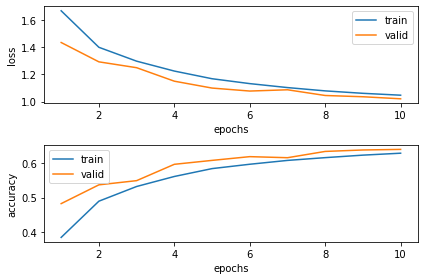

In [42]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [43]:
model_filepath = os.path.join(MODEL_DIR, "model_4.pkl")
torch.save(model_4, model_filepath)

#### Evaluate

In [44]:
true_values, pred_values = evaluate(model_4, test_dl)
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.641
--
confusion matrix
[[727  32  65  13  14   3  12   7  85  42]
 [ 32 780   9   5   5   2  10   7  44 106]
 [100  14 519  55  89  66  86  35  22  14]
 [ 24  15 107 426  87 156  83  43  30  29]
 [ 38  11 121  57 555  30  82  83  19   4]
 [ 12   4 103 201  57 503  27  62  15  16]
 [  8   7  64  58  42  17 773   9  10  12]
 [ 19   6  38  41  82  78   8 695   9  24]
 [118  57  14   9   3   6   9   5 743  36]
 [ 36 135  13  14   5   6  16  26  58 691]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.65      0.73      0.69      1000
  automobile       0.74      0.78      0.76      1000
        bird       0.49      0.52      0.51      1000
         cat       0.48      0.43      0.45      1000
        deer       0.59      0.56      0.57      1000
         dog       0.58      0.50      0.54      1000
        frog       0.70      0.77      0.73      1000
       horse       0.72      0.69      0.70      1000
        ship      

In [45]:
metric_filepath = os.path.join(MODEL_DIR, "model_4.json")
write_metrics(true_values, pred_values, "dropout_dense", metric_filepath)

### Dropout (after Conv layers only)

#### Model

In [46]:
model_5 = Cifar10Classifier(use_spatial_dropout=True)
model_5 = model_5.to(dev)

optimizer = torch.optim.Adam(model_5.parameters(), lr=LEARNING_RATE*2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

#### Train

In [47]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_5, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_5, test_dl, loss_fn)
  print("Epoch {:2d} (LR: {:.3e}) | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, scheduler.get_last_lr()[0], train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  scheduler.step()

Epoch  1 (LR: 2.000e-03) | Train Loss: 1.677, Accuracy: 0.389 | Validation Loss: 1.369, Accuracy: 0.509
Epoch  2 (LR: 1.600e-03) | Train Loss: 1.381, Accuracy: 0.510 | Validation Loss: 1.229, Accuracy: 0.566
Epoch  3 (LR: 1.280e-03) | Train Loss: 1.257, Accuracy: 0.557 | Validation Loss: 1.124, Accuracy: 0.601
Epoch  4 (LR: 1.024e-03) | Train Loss: 1.180, Accuracy: 0.588 | Validation Loss: 1.076, Accuracy: 0.627
Epoch  5 (LR: 8.192e-04) | Train Loss: 1.130, Accuracy: 0.605 | Validation Loss: 1.036, Accuracy: 0.640
Epoch  6 (LR: 6.554e-04) | Train Loss: 1.093, Accuracy: 0.618 | Validation Loss: 1.011, Accuracy: 0.647
Epoch  7 (LR: 5.243e-04) | Train Loss: 1.059, Accuracy: 0.628 | Validation Loss: 1.001, Accuracy: 0.652
Epoch  8 (LR: 4.194e-04) | Train Loss: 1.038, Accuracy: 0.638 | Validation Loss: 0.978, Accuracy: 0.658
Epoch  9 (LR: 3.355e-04) | Train Loss: 1.025, Accuracy: 0.643 | Validation Loss: 0.972, Accuracy: 0.662
Epoch 10 (LR: 2.684e-04) | Train Loss: 1.009, Accuracy: 0.650 | 

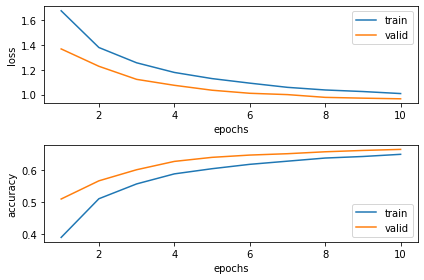

In [48]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [49]:
model_filepath = os.path.join(MODEL_DIR, "model_5.pkl")
torch.save(model_5, model_filepath)

#### Evaluate

In [50]:
true_values, pred_values = evaluate(model_5, test_dl)
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.666
--
confusion matrix
[[706  26  39  21  16   8   5  13 121  45]
 [ 19 807   8   5   5   6   7   2  42  99]
 [ 70  11 486  44 127 105  68  46  22  21]
 [ 25  16  66 421 101 189  84  39  27  32]
 [ 29   3  78  59 643  30  64  67  21   6]
 [ 17   4  49 166  60 579  35  62  14  14]
 [ 10  13  36  56  64  26 764   5  17   9]
 [ 18   8  29  37  80  74   9 717   3  25]
 [ 68  51   7  14   8   7   3   5 809  28]
 [ 40 120   9  19   7   7   9  15  46 728]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.70      0.71      0.71      1000
  automobile       0.76      0.81      0.78      1000
        bird       0.60      0.49      0.54      1000
         cat       0.50      0.42      0.46      1000
        deer       0.58      0.64      0.61      1000
         dog       0.56      0.58      0.57      1000
        frog       0.73      0.76      0.75      1000
       horse       0.74      0.72      0.73      1000
        ship      

In [51]:
metric_filepath = os.path.join(MODEL_DIR, "model_5.json")
write_metrics(true_values, pred_values, "dropout_conv", metric_filepath)

### Dropout (Conv + Dense Layers)

#### Model

In [52]:
model_6 = Cifar10Classifier(use_dropout=True, use_spatial_dropout=True)
model_6 = model_6.to(dev)

optimizer = torch.optim.Adam(model_6.parameters(), lr=LEARNING_RATE*2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

#### Train

In [53]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model_6, train_dl, loss_fn, optimizer)
  val_loss, val_acc = validate(model_6, test_dl, loss_fn)
  print("Epoch {:2d} (LR: {:.3e}) | Train Loss: {:.3f}, Accuracy: {:.3f} | Validation Loss: {:.3f}, Accuracy: {:.3f}".format(
      epoch, scheduler.get_last_lr()[0], train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  scheduler.step()

Epoch  1 (LR: 2.000e-03) | Train Loss: 1.734, Accuracy: 0.365 | Validation Loss: 1.384, Accuracy: 0.503
Epoch  2 (LR: 1.600e-03) | Train Loss: 1.439, Accuracy: 0.483 | Validation Loss: 1.240, Accuracy: 0.561
Epoch  3 (LR: 1.280e-03) | Train Loss: 1.347, Accuracy: 0.524 | Validation Loss: 1.159, Accuracy: 0.599
Epoch  4 (LR: 1.024e-03) | Train Loss: 1.284, Accuracy: 0.545 | Validation Loss: 1.113, Accuracy: 0.616
Epoch  5 (LR: 8.192e-04) | Train Loss: 1.241, Accuracy: 0.560 | Validation Loss: 1.078, Accuracy: 0.629
Epoch  6 (LR: 6.554e-04) | Train Loss: 1.206, Accuracy: 0.574 | Validation Loss: 1.056, Accuracy: 0.637
Epoch  7 (LR: 5.243e-04) | Train Loss: 1.185, Accuracy: 0.581 | Validation Loss: 1.040, Accuracy: 0.642
Epoch  8 (LR: 4.194e-04) | Train Loss: 1.169, Accuracy: 0.586 | Validation Loss: 1.035, Accuracy: 0.646
Epoch  9 (LR: 3.355e-04) | Train Loss: 1.156, Accuracy: 0.595 | Validation Loss: 1.013, Accuracy: 0.651
Epoch 10 (LR: 2.684e-04) | Train Loss: 1.142, Accuracy: 0.597 | 

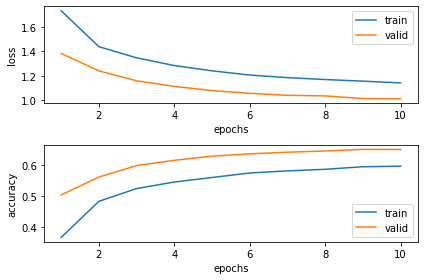

In [54]:
plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [55]:
model_filepath = os.path.join(MODEL_DIR, "model_6.pkl")
torch.save(model_6, model_filepath)

#### Evaluate

In [56]:
true_values, pred_values = evaluate(model_6, test_dl)
print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
print("--")
print("confusion matrix")
print(confusion_matrix(true_values, pred_values))
print("--")
print("classification report")
print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

** accuracy: 0.651
--
confusion matrix
[[671  19  52  24  13   4  10  10 142  55]
 [ 15 765   7   9   3   7  13   2  41 138]
 [ 68  14 446  80 101 102 110  40  19  20]
 [ 15  12  63 469  65 187 107  42  22  18]
 [ 29   4  74  64 552  40 114  99  18   6]
 [ 16   8  54 182  39 582  43  52  11  13]
 [  4   6  39  70  42  18 797   8   6  10]
 [ 15   4  32  60  65  85  14 689   5  31]
 [ 75  44   9  12   6  11   8   6 797  32]
 [ 42 114   5  14   7   5  16  16  43 738]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.71      0.67      0.69      1000
  automobile       0.77      0.77      0.77      1000
        bird       0.57      0.45      0.50      1000
         cat       0.48      0.47      0.47      1000
        deer       0.62      0.55      0.58      1000
         dog       0.56      0.58      0.57      1000
        frog       0.65      0.80      0.71      1000
       horse       0.71      0.69      0.70      1000
        ship      

In [57]:
metric_filepath = os.path.join(MODEL_DIR, "model_6.json")
write_metrics(true_values, pred_values, "dropout_both", metric_filepath)

### Model Comparison

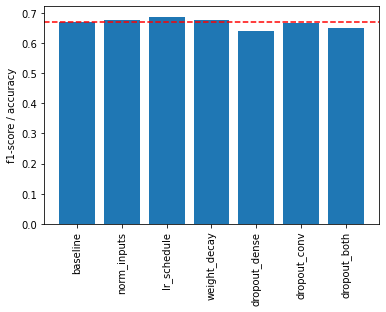

In [58]:
json_files = []
for f in os.listdir(MODEL_DIR):
  if f.endswith(".json"):
    json_files.append(f)

xs, ps, rs, fs = [], [], [], []
for json_file in sorted(json_files):
  with open(os.path.join(MODEL_DIR, json_file), "r") as f:
    metrics_dict = json.loads(f.read())
    xs.append(metrics_dict["name"])
    ps.append(metrics_dict["precision"])
    rs.append(metrics_dict["recall"])
    fs.append(metrics_dict["f1-score"])

plt.bar(np.arange(len(fs)), fs)
plt.ylabel("f1-score / accuracy")
plt.xticks(np.arange(len(fs)), xs, rotation="90")
plt.axhline(fs[0], 0, len(fs), color="r", linestyle="--")
_ = plt.show()

In [59]:
fidx_max, fidx_min = np.argmax(fs), np.argmin(fs)
print("Best results using {:s}: F1-score : {:.3f}".format(
    xs[fidx_max], fs[fidx_max]))
print("Worst results using {:s}: F1-score: {:.3f}".format(
    xs[fidx_min], fs[fidx_min]))

Best results using lr_schedule: F1-score : 0.688
Worst results using dropout_dense: F1-score: 0.641
